In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm
from itertools import product

# Функции для создания Ngram

In [2]:
def get_txt_by_words(txt):
    """Разбитие исходного текста на слова"""
    txt = re.sub('\s+', ' ', re.sub(r'[^\w\s]', ' ', txt))
    txt_by_words = [x.lower() for x in re.split('\s', txt) if len(x)>0 and re.fullmatch('\w+', x)]
    return txt_by_words

In [3]:
def construct_ngrams2(txt):
    """Подсчёт 2Ngram"""
    res = {}
    txt_by_words = get_txt_by_words(txt)
    for w0, w1 in tqdm(zip(txt_by_words[:-1], txt_by_words[1:]), total=len(txt_by_words)-1):
        itm = f"{w0} {w1}"
        res[itm] = res.get(itm,0)+1
    return res

In [4]:
def construct_ngrams3(txt):
    """Подсчёт 3Ngram"""
    res = {}
    txt_by_words = get_txt_by_words(txt)
    for w0, w1, w2 in tqdm(zip(txt_by_words[:-2], txt_by_words[1:-1], txt_by_words[2:]),
                           total=len(txt_by_words)-2):
        itm = f"{w0} {w1} {w2}"
        res[itm] = res.get(itm,0)+1
    return res

In [5]:
def prepare_ngrams_ds(ds):
    """Подсчёт статистики по NGram'ам"""
    N = len(ds['Item'].values[0].split(' '))
    fs = [f'word_{idx}' for idx in range(N)]
    for f in fs:
        ds[f] = [x.split(' ')[int(f.split('_')[1])] for x in ds['Item']]
        
    d = ds.groupby(fs[:-1])['Freq'].sum().reset_index().rename(columns={'Freq':'Freq_base'})
    ds = pd.merge(ds, d, on=fs[:-1])
    ds['item_freq'] = ds['Freq']/ds['Freq_base']
    ds['Item_base'] = [' '.join(x.split(' ')[:N-1]) for x in ds['Item']]
    ds.index = ds['Item']
    ds = ds.drop('Item',1)
    return ds

In [6]:
def phrase_probability(phrase, ds, alpha):
    """Расчёт вероятности встретить фразу
    * phrase - фраза для расчёта
    * ds - датасет с 2нграммами, 3нграммами
    * alpha - константа для сглаживания
    """
    phrase = phrase.replace(',','').lower().split(' ')
    
    N = len([f for f in ds.columns if f.startswith('word_')])
    V = ds['Item_base'].nunique() if alpha!=0 else 0
    
    ss = [' '.join(x) for x in zip(phrase[:-1], phrase[1:])] if N==2\
        else [' '.join(x) for x in zip(phrase[:-2],phrase[1:-1], phrase[2:])]
    ss_base = [' '.join(s.split(' ')[:-1]) for s in ss]
    
    
    p = ds.loc[ds['Item_base']==ss_base[0], 'Freq_base'].values[0] if ss_base[0] in ds['Item_base'].values else 0
    p = (p+alpha)/(ds['Freq'].sum()+V)
    
    p *= np.prod(np.array([ds.loc[s,'Freq'] if s in ds.index else 0 for s in ss])+alpha, dtype='float64')
    ps_base = np.prod(np.array([(ds.loc[ds['Item_base']==s,'Freq_base'].values[0])
                               if s in ds['Item_base'].values else 0
                               for s in ss_base])+V, dtype='float64')
    #print(np.array([(ds.loc[ds['Item_base']==s,'Freq_base'].values[0])
    #                           if s in ds['Item_base'].values else 0
    #                           for s in ss_base])+V)
    #print(ps_base)
    p = p/ps_base if ps_base>0 else 0
    
    return p

# Подготовка данных

In [7]:
# Фразы, которые были в тексте
phrases_true = ["Матушка сидела в гостиной и разливала чай", #Том1 детство
               "И он ударил вилкой по столу", #Том 1 детство
               "в карты не играл, кутил редко и курил простой табак", #Том 3. Произведения 1852
               "Длинные чистые сакли с плоскими земляными крышами и красивыми трубами были расположены по неровным каменистым буграм, между которыми текла небольшая река", #Том 3. Произведения 1852
                "Не видя никого в избе, Нехлюдов хотел уже выйти, как протяжный, влажный вздох изобличил хозяина" #Том4 Прозведения севастопольского периода. утро помещика
               ]
# Фразы, которых не было в тексте
phrases_false = [
    "Но вот где является в полном блеске историческое воззрение г. Маркова", #Том 8. Педагогические статьи 1860
    "Что же это такое понятие прогресса и вера в него", # Том8. Педагогические статьи 1860
    "Высунувшееся из кареты лицо Наташи сияло насмешливою ласкою", #Том9. Война и мир
    "Наполеон испытывал то несколько завистливое и беспокойное любопытство, которое испытывают люди при виде форм не знающей о них, чуждой жизни", #Том9. Война и мир
    "Несколько купцов столпились около офицера", # Том9. Война и мир
]

In [8]:
# Исходные файлы
txts = []
for fname in [
    'Толстой Лев. Полное собрание сочинений. Том 1. Детство - royallib.com.txt',
    'Толстой Лев. Полное собрание сочинений. Том 2. Юность - royallib.com.txt',
    'Толстой Лев. Полное собрание сочинений. Том 3. Произведения 1852.txt',
    'Толстой Лев. Полное собрание сочинений. Том 4. Произведения севастопольского периода. Утро помещика - royallib.com.txt',
    'Толстой Лев. Полное собрание сочинений. Том 5. Произведения 1856.txt'
]:
    with open('../../data/texts/'+fname) as f:
        txt = f.read()
    txts.append(txt)
txt = ' '.join(txts[:-1]) #Последний текст оставим для расчёта перплексии

In [9]:
# Доп. проверка, что нужные фразы есть в тексте, ненужных - нет
assert all(p in txt for p in phrases_true), 'Some "True" phrases are not in the corpus'
assert all(p not in txt for p in phrases_false), 'Some "False" phrases are in the corpus'

Расчёт собственных 2ngram и 3ngram

In [10]:
res = construct_ngrams2(txt)
my_ng2 = pd.DataFrame([{'Item':k, 'Freq': v} for k,v in res.items()])
my_ng2 = prepare_ngrams_ds(my_ng2)
print(my_ng2.shape)


(224437, 6)


In [11]:
res = construct_ngrams3(txt)
my_ng3 = pd.DataFrame([{'Item':k, 'Freq': v} for k,v in res.items()])
my_ng3 = prepare_ngrams_ds(my_ng3)
print(my_ng3.shape)


(321722, 7)


Загрузка ngram от SketchEngine

In [12]:
sk_ng2 = pd.read_excel('../../data/2ngrams_user_edudyrev_earlytolstoy_20200308162713.xls')
sk_ng3 = pd.read_excel('../../data/3ngrams_user_edudyrev_earlytolstoy_20200308162610.xls')
sk_ng2 = prepare_ngrams_ds(sk_ng2)
sk_ng3 = prepare_ngrams_ds(sk_ng3)
print('n==2', sk_ng2.shape)
print('n==3', sk_ng3.shape)
sk_ng2.head()

n==2 (12844, 6)
n==3 (3407, 7)


,Freq,word_0,word_1,Freq_base,item_freq,Item_base
Item,,,,,,
нет в,555,нет,в,617,0.899514,нет
нет ни,8,нет,ни,617,0.012966,нет
нет соответствующего,7,нет,соответствующего,617,0.011345,нет
нет расчета,6,нет,расчета,617,0.009724,нет
нет ничего,6,нет,ничего,617,0.009724,нет


In [13]:
sk_ng2['Freq'].min()

3

Минимальная частота нграммы в датасете от SketchEngine - 3. Что странно, т.к. в настройках была указана минимальная частота 0.

# Вероятности тестовых фраз

In [14]:
print('Вероятности для фраз из текста\n')
for p in phrases_true:
    print(f"{p}\nMy 2ngrams:           {phrase_probability(p.replace(',',''), my_ng2,0):.2e}\nSketchEngine 2Ngrams: {phrase_probability(p, sk_ng2, 0):.2f}\n===================================\n")

Вероятности для фраз из текста

Матушка сидела в гостиной и разливала чай
My 2ngrams:           1.78e-15
SketchEngine 2Ngrams: 0.00

И он ударил вилкой по столу
My 2ngrams:           4.03e-11
SketchEngine 2Ngrams: 0.00

в карты не играл, кутил редко и курил простой табак
My 2ngrams:           8.45e-19
SketchEngine 2Ngrams: 0.00

Длинные чистые сакли с плоскими земляными крышами и красивыми трубами были расположены по неровным каменистым буграм, между которыми текла небольшая река
My 2ngrams:           6.73e-30
SketchEngine 2Ngrams: 0.00

Не видя никого в избе, Нехлюдов хотел уже выйти, как протяжный, влажный вздох изобличил хозяина
My 2ngrams:           7.33e-25
SketchEngine 2Ngrams: 0.00



In [15]:
print('Вероятности для фраз не из текста\n')
for p in phrases_false:
    print(f"{p}\nMy 2ngrams:           {phrase_probability(p.replace(',',''), my_ng2,0):.2e}\nSketchEngine 2Ngrams: {phrase_probability(p, sk_ng2, 0):.2f}\n===================================\n")

Вероятности для фраз не из текста

Но вот где является в полном блеске историческое воззрение г. Маркова
My 2ngrams:           0.00e+00
SketchEngine 2Ngrams: 0.00

Что же это такое понятие прогресса и вера в него
My 2ngrams:           0.00e+00
SketchEngine 2Ngrams: 0.00

Высунувшееся из кареты лицо Наташи сияло насмешливою ласкою
My 2ngrams:           0.00e+00
SketchEngine 2Ngrams: 0.00

Наполеон испытывал то несколько завистливое и беспокойное любопытство, которое испытывают люди при виде форм не знающей о них, чуждой жизни
My 2ngrams:           0.00e+00
SketchEngine 2Ngrams: 0.00

Несколько купцов столпились около офицера
My 2ngrams:           0.00e+00
SketchEngine 2Ngrams: 0.00



# Подсчёт статистики

Параметры для расчёта

In [16]:
pars_sourse = ['me','se']
pars_n = [2,3]
#pars_alpha = [0,  0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3,1]
pars_alpha = list(np.logspace(-10,1, 10))
pars = product(pars_sourse, pars_n, pars_alpha)

Собственно расчёт

In [17]:
ng_dss = {('me',2): my_ng2, ('me',3):my_ng3, ('se',2):sk_ng2, ('se',3):sk_ng3}
ress = []
for p in tqdm(phrases_true+phrases_false):
    for par in product(pars_sourse, pars_n, pars_alpha):
        src, N, alpha = par
        res = {'phrase':p, 'sourse':src, 'N':N, 'alpha':alpha, 'type':p in phrases_true}
        res['prob'] = phrase_probability(p, ng_dss[(src,N)], alpha)
        ress.append(pd.Series(res))
res = pd.concat(ress,1).T
for f in ['alpha','prob']:
    res[f] = res[f].astype(float)
res['prob_log'] = np.log1p(res['prob']*1e152)
res['alpha_log'] = np.log1p(res['alpha']*1e5)
res['phrase_short'] = [' '.join(x.split(' ')[:3]) + ('...'  if len(x.split(' '))>3 else '') for x in res['phrase']]
print(res.shape)
res.head()


(400, 9)


,phrase,sourse,N,alpha,type,prob,prob_log,alpha_log,phrase_short
0,Матушка сидела в гостиной и разливала чай,me,2,1.000000e-10,True,2.892283e-31,279.674843,0.000010,Матушка сидела в...
1,Матушка сидела в гостиной и разливала чай,me,2,1.668101e-09,True,2.892283e-31,279.674843,0.000167,Матушка сидела в...
2,Матушка сидела в гостиной и разливала чай,me,2,2.782559e-08,True,2.892284e-31,279.674843,0.002779,Матушка сидела в...
3,Матушка сидела в гостиной и разливала чай,me,2,4.641589e-07,True,2.892289e-31,279.674845,0.045371,Матушка сидела в...
4,Матушка сидела в гостиной и разливала чай,me,2,7.742637e-06,True,2.892379e-31,279.674875,0.573386,Матушка сидела в...


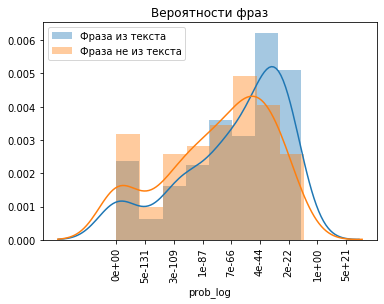

In [18]:
for v in res['type'].unique():
    sns.distplot(res[res['type']==v]['prob_log'], label={True:'Фраза из текста',False:'Фраза не из текста'}[v])
#sns.distplot(res['prob_log'])
plt.legend()
xticks = np.expm1([0,50,100,150,200,250,300,350,400])/1e152
plt.xticks(np.log1p(xticks*1e152), [f"{x:.0e}" for x in xticks], rotation=90)
plt.title('Вероятности фраз')
plt.show()

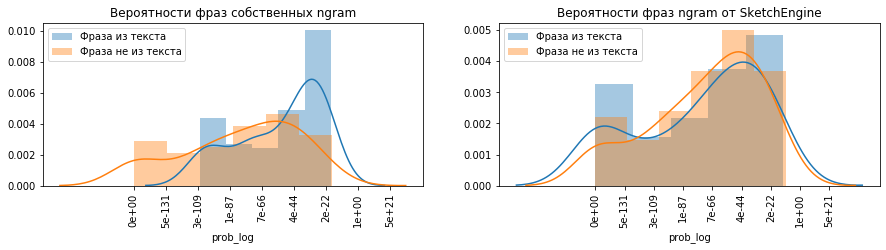

In [19]:
plt.figure(figsize=(15,3))

for idx, s in enumerate(['me','se']):
    plt.subplot(1,2,idx+1)
    for v in res['type'].unique():
        sns.distplot(res[(res['type']==v)&(res['sourse']==s)]['prob_log'],
                     label={True:'Фраза из текста',False:'Фраза не из текста'}[v])
    plt.legend()
    xticks = np.expm1([0,50,100,150,200,250,300,350,400])/1e152
    plt.xticks(np.log1p(xticks*1e152), [f"{x:.0e}" for x in xticks], rotation=90)
    plt.title(f"Вероятности фраз " + {'me':'собственных ngram', 'se':'ngram от SketchEngine'}[s])

plt.show()

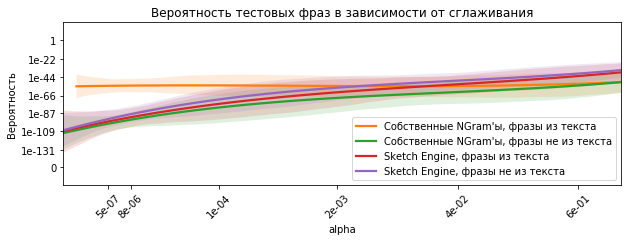

In [21]:
plt.figure(figsize=(10,3))
sns.regplot(x='alpha_log', y='prob_log', data=res[(res['sourse']=='me')&(res['type']==True)],
            order=3, fit_reg=False, scatter_kws={'alpha':0}, line_kws={'alpha':0}, label='' )
sns.regplot(x='alpha_log', y='prob_log', data=res[(res['sourse']=='me')&(res['type']==True)],
            order=3, scatter=False, label='Собственные NGram\'ы, фразы из текста')
sns.regplot(x='alpha_log', y='prob_log', data=res[(res['sourse']=='me')&(res['type']==False)],
            order=3, scatter=False, label='Собственные NGram\'ы, фразы не из текста')
sns.regplot(x='alpha_log', y='prob_log', data=res[(res['sourse']=='se')&(res['type']==True)],
            order=3, scatter=False, label='Sketch Engine, фразы из текста')
sns.regplot(x='alpha_log', y='prob_log', data=res[(res['sourse']=='se')&(res['type']==False)],
            order=3, scatter=False, label='Sketch Engine, фразы не из текста')

plt.xticks(res['alpha_log'].unique()[3:], [f"{x:.0e}" for x in res['alpha'].unique()[3:]], rotation=45)
yticks = np.array([0, 1e-131, 1e-109, 1e-87, 1e-66, 1e-44, 1e-22, 1])
plt.yticks(np.log1p(yticks*1e152), [f"{x:.0e}" if x not in [0,1] else f"{x:.0f}" for x in yticks])
plt.ylabel('Вероятность')
plt.xlabel('alpha')
plt.title('Вероятность тестовых фраз в зависимости от сглаживания')
plt.ylim((-50,400))#plt.ylim()[1]))
plt.xlim((-1,12))
plt.legend()
plt.show()

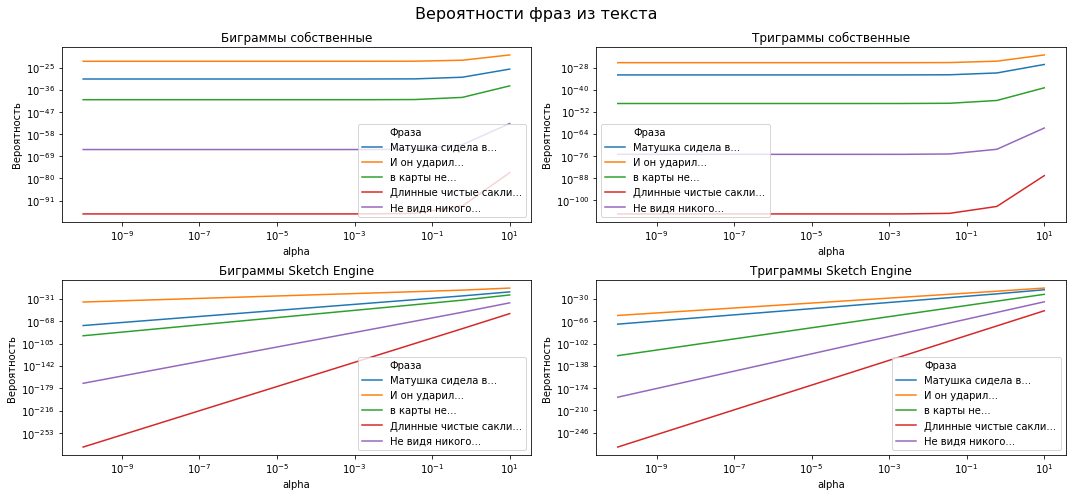

In [22]:
cds = res[res['type']==True]
cds = cds.rename(columns={'phrase_short':'Фраза','prob':'Вероятность'})

plt.figure(figsize=(15,7))
plt.subplot(221)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='me')&(cds['N']==2)])
plt.xscale('log')
plt.yscale('log')
plt.title('Биграммы собственные')

plt.subplot(222)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='me')&(cds['N']==3)])
plt.xscale('log')
plt.yscale('log')
plt.title('Триграммы собственные')

plt.subplot(223)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='se')&(cds['N']==2)])
plt.xscale('log')
plt.yscale('log')
plt.title('Биграммы Sketch Engine')

plt.subplot(224)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='se')&(cds['N']==3)])
plt.xscale('log')
plt.yscale('log')
plt.title('Триграммы Sketch Engine')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Вероятности фраз из текста', size=16)

plt.show()

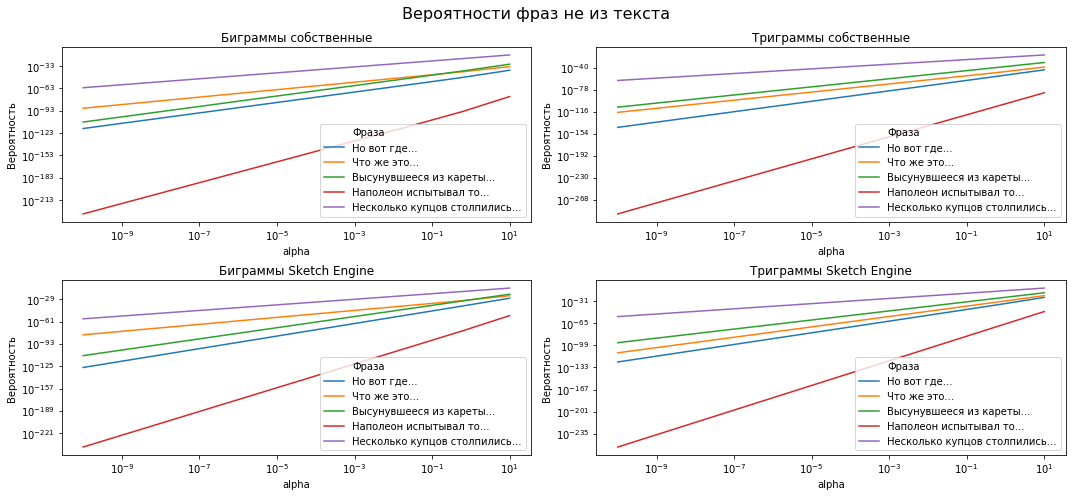

In [23]:
cds = res[res['type']==False]
cds = cds.rename(columns={'phrase_short':'Фраза','prob':'Вероятность'})

plt.figure(figsize=(15,7))
plt.subplot(221)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='me')&(cds['N']==2)])
plt.xscale('log')
plt.yscale('log')
plt.title('Биграммы собственные')

plt.subplot(222)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='me')&(cds['N']==3)])
plt.xscale('log')
plt.yscale('log')
plt.title('Триграммы собственные')


plt.subplot(223)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='se')&(cds['N']==2)])
plt.xscale('log')
plt.yscale('log')
plt.title('Биграммы Sketch Engine')

plt.subplot(224)
sns.lineplot(x='alpha', y='Вероятность', hue='Фраза', data=cds[(cds['sourse']=='se')&(cds['N']==3)])
plt.xscale('log')
plt.yscale('log')
plt.title('Триграммы Sketch Engine')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Вероятности фраз не из текста', size=16)

plt.show()

# Расчёт перплексии

In [24]:
def perplex(txt, ds, alpha):
    N = len(get_txt_by_words(txt))
    p = phrase_probability(txt, ds, alpha)
    pp = p**(-1/N) if p!= 0 else np.inf
    return pp

Для расчёта перплексии возмём текст из 50 слов, не использовавшийся при обучении Ngram.

In [25]:
txt_short = ' '.join(get_txt_by_words(txts[-2])[1000:1050])
txt_short

'в сноске а в других самых редких случаях с оговоркой в сноске абзац редактора примечания и переводы иностранных слов и выражений принадлежащие толстому и печатаемые в сносках внизу страницы печатаются петитом без скобок переводы иностранных слов и выражений принадлежащие редактору печатаются в прямых скобках обозначения в оглавлении томов на шмуцтитулах'

Расчёт перплексии

In [26]:
ress = []
for N in [2,3]:
    for s in ['me','se']:
        for a in [0, 1]:
            res = {'N':N, 'source':s,'alpha':a, 'pp': perplex(txt_short, ng_dss[(s,N)], a)}
            ress.append(pd.Series(res))
res = pd.concat(ress, 1).T
m = max([x for x in res['pp'] if x!=np.inf])
res['pp'] = [x if x!=np.inf else m*10 for x in res['pp']]
res['pp_log'] = np.log1p(res['pp'])
res['pp_verb'] = [f"{x:.0f}" if x!=max(res['pp']) else '$\infty$' for x in res['pp']]

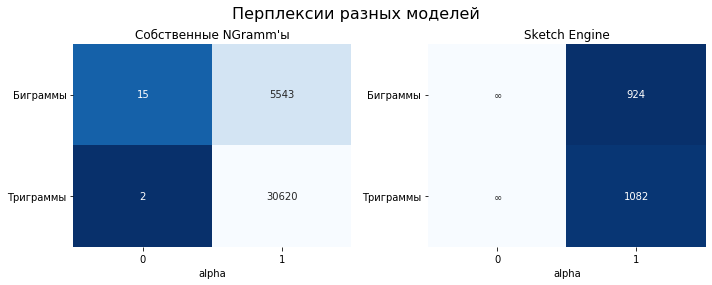

In [27]:
plt.figure(figsize=(10,4))
for idx, s in enumerate(['me','se']):
    plt.subplot(1,2,idx+1)
    cds = res[res['source']==s]
    sns.heatmap(cds.pivot(index='N',columns='alpha',values='pp_log'),
                cmap='Blues_r', cbar=False, fmt='',
                annot=cds.pivot(index='N',columns='alpha',values='pp_verb'))
    plt.ylim((0,2))
    plt.yticks(plt.yticks()[0], [{'2':'Биграммы','3':'Триграммы'}[y.get_text()] for y in plt.yticks()[1]],
              rotation=0)
    plt.ylabel('')
    plt.gca().invert_yaxis()
    plt.title({'me':'Собственные NGramm\'ы','se':'Sketch Engine'}[s])    

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle('Перплексии разных моделей', size=16)
plt.show()